In [ ]:
pip install pmdarima

In [1]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

/Users/rush/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [136]:
calendar = pd.read_csv('calendar.csv')
calendar_events = pd.read_csv('calendar_events.csv')
sales_test = pd.read_csv('sales_test.csv')
sales_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items_weekly_sell_prices.csv')

In [142]:
sales_test = pd.read_csv('sales_test.csv')

test_df = pd.concat([sales_train[id_cols], sales_test], axis=1)

test_df = makedf(test_df)

In [139]:
# Columns to keep as identifiers
id_cols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

def makedf(data):
    
    df = pd.melt(data, id_vars=id_cols, var_name='d', value_name='qty')
    df = pd.merge(df, calendar, how='left', on='d')
    df = pd.merge(df, items, how='left', on=['store_id',	'item_id',	'wm_yr_wk'])
    df['sell_price'].fillna(0, inplace=True)
    df['revenue'] = df['qty'] * df['sell_price']

    grouped_df = df.groupby('date')['revenue'].sum().reset_index()
    grouped_df.columns = ['date', 'revenue']

    grouped_df = pd.merge(grouped_df, calendar_events, how='left', on='date') 
    grouped_df = pd.get_dummies(grouped_df, columns=['event_type'], prefix=['event'])
    
    grouped_df['date'] = pd.to_datetime(grouped_df['date'])
    grouped_df['date'] = grouped_df.set_index('date', inplace=True)
    grouped_df.index = pd.DatetimeIndex(grouped_df.index).to_period('D')
    grouped_df = grouped_df.to_timestamp()
    
    return grouped_df

sales_test = pd.concat([sales_train[id_cols], sales_test], axis=1)

train_df = makedf(sales_train)
test_df = makedf(sales_test)

ValueError: Per-column arrays must each be 1-dimensional

In [179]:
import pmdarima as pm

auto_arima_model = pm.auto_arima(train_df['revenue'], seasonal=True, trace=True)




Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=33458.602, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=34341.075, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=34334.265, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=34325.167, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=34339.081, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=33660.053, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=33341.871, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=33624.951, Time=0.38 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=32864.207, Time=1.43 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=33443.166, Time=0.33 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=32765.506, Time=1.52 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=33062.449, Time=0.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=32758.543, Time=1.61 sec
 ARIMA(4,1,3)(0,0,0)[0] i

In [180]:
auto_arima_model.fit(train_df['revenue'])

forecast, conf_int = auto_arima_model.predict(n_periods=len(test_df), return_conf_int=True)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(test_df['revenue'], forecast)
print(f"Mean Absolute Error (MAE): {mae}")


Mean Absolute Error (MAE): 11460.539286187442


/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


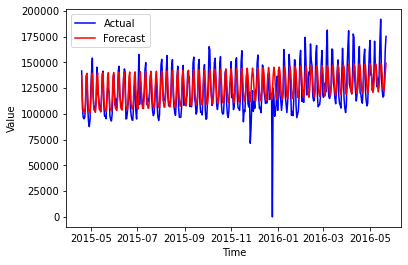

In [181]:
import matplotlib.pyplot as plt

# Assuming you have 'test_data' (actual values) and 'forecast' (forecasted values) as defined in the previous response

# Plot the actual values
plt.plot(test_df.index, test_df['revenue'], label='Actual', color='blue')

# Plot the forecasted values
plt.plot(test_df.index, forecast, label='Forecast', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Show the plot
plt.show()


In [182]:
calendar_events.head()

,date,event_name,event_type
0,2011-02-06,SuperBowl,Sporting
1,2011-02-14,ValentinesDay,Cultural
2,2011-02-21,PresidentsDay,National
3,2011-03-09,LentStart,Religious
4,2011-03-16,LentWeek2,Religious


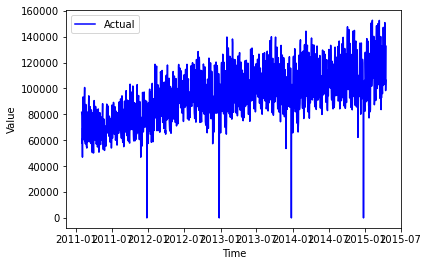

In [176]:
import matplotlib.pyplot as plt

# Assuming you have 'test_data' (actual values) and 'forecast' (forecasted values) as defined in the previous response
train_df = train_df.to_timestamp()
# Plot the actual values
plt.plot(train_df.index, train_df['revenue'], label='Actual', color='blue')


# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Show the plot
plt.show()


/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                              revenue   No. Observations:                 1545
Model:             SARIMAX(3, 2, 6)x(0, 1, [1], 12)   Log Likelihood              -17293.505
Date:                              Thu, 05 Oct 2023   AIC                          34617.010
Time:                                      10:52:49   BIC                          34697.015
Sample:                                  01-29-2011   HQIC                         34646.784
                                       - 04-18-2015                                         
Covariance Type:                                opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
event_National     63.8233   3722.625      0.017      0.986   -7232.388    7360.034
even

TypeError: Axis must have `freq` set to convert to Periods

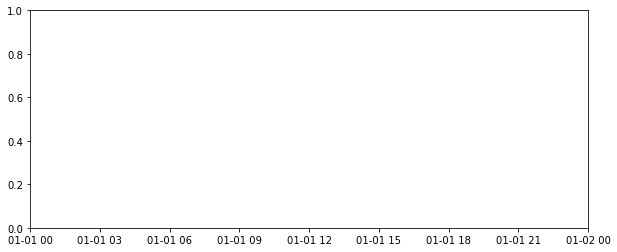

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_df.index = pd.DatetimeIndex(train_df.index).to_period('D')
    # Define the ARIMA model parameters
p = 3  # Order of the autoregressive (AR) component
d = 2  # Order of differencing (usually 1 or 2)
q = 6  # Order of the moving average (MA) component

    # Create and fit the ARIMA model
# Define the SARIMAX model with exogenous variables
model = SARIMAX(train_df['revenue'], exog=train_df[['event_National', 'event_Cultural', 'event_Sporting', 'event_Religious']], order=(p, d, q), seasonal_order=(0, 1, 1, 12)) #
#model = sm.tsa.ARIMA(train_df, order=(p, d, q))
results = model.fit()

print(results.summary())

residuals = results.resid
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

forecast_steps = 400  # Number of time steps into the future to forecast
forecast = results.forecast(steps=forecast_steps, exog=test_df[['event_Cultural','event_National','event_Religious','event_Sporting']])
forecast = pd.DataFrame(forecast)

forecast = forecast.to_timestamp()
forecast.index = pd.to_datetime(forecast.index)

# Plot the original time series and the forecast
plt.figure(figsize=(12, 6))
plt.plot(test_df.index, test_df['revenue'], label='Original Time Series')
plt.plot(forecast['predicted_mean'], label='Forecast', linestyle='--')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

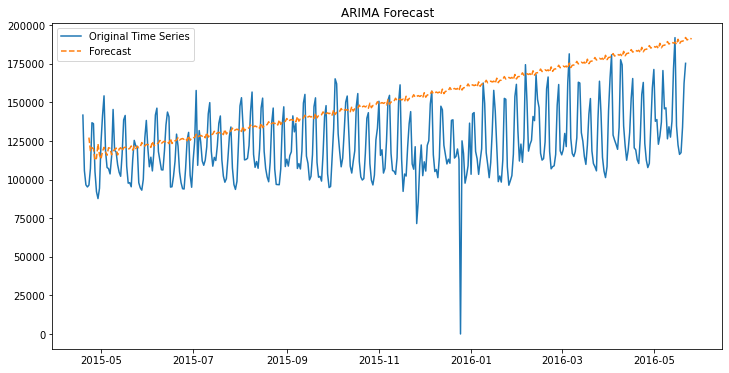

In [163]:
forecast.index = forecast.index.date
merged_df = test_df.merge(forecast, left_index=True, right_index=True, how='left')
merged_df.head()


AttributeError: 'PeriodIndex' object has no attribute 'date'

In [183]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [192]:
data = pd.DataFrame()
data['y'] = train_df['revenue']
data.reset_index(inplace=True, names='ds')
data.head()

,ds,y
0,2011-01-29,81650.61
1,2011-01-30,78970.57
2,2011-01-31,57706.91
3,2011-02-01,60761.20
4,2011-02-02,46959.95


In [200]:
data_test = pd.DataFrame()
data_test['y'] = test_df['revenue']
data_test.reset_index(inplace=True, names='ds')
data_test.head()

,ds,y
0,2015-04-19,141758.65
1,2015-04-20,105781.23
2,2015-04-21,96606.05
3,2015-04-22,95237.65
4,2015-04-23,96460.08


In [193]:
holidays = pd.DataFrame()
holidays['holiday'] = calendar_events['event_name']
holidays['ds'] = pd.to_datetime(calendar_events['date'])

11:49:42 - cmdstanpy - INFO - Chain [1] start processing
11:49:42 - cmdstanpy - INFO - Chain [1] done processing


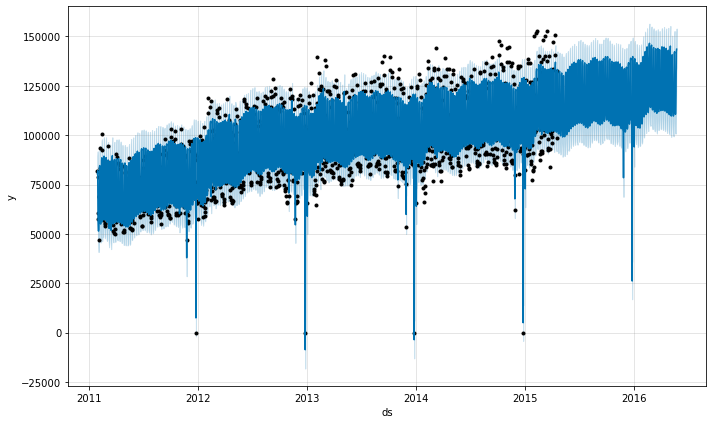

In [194]:
from prophet import Prophet


# Initialize and fit the model
model = Prophet(holidays=holidays)
model.fit(data)

# Make forecasts
future = model.make_future_dataframe(periods=400)
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)


In [195]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chanukah End,Chanukah End_lower,Chanukah End_upper,Christmas,Christmas_lower,Christmas_upper,Cinco De Mayo,Cinco De Mayo_lower,Cinco De Mayo_upper,ColumbusDay,ColumbusDay_lower,ColumbusDay_upper,Easter,Easter_lower,Easter_upper,Eid al-Fitr,Eid al-Fitr_lower,Eid al-Fitr_upper,EidAlAdha,EidAlAdha_lower,EidAlAdha_upper,Father's day,Father's day_lower,Father's day_upper,Halloween,Halloween_lower,Halloween_upper,IndependenceDay,IndependenceDay_lower,IndependenceDay_upper,LaborDay,LaborDay_lower,LaborDay_upper,LentStart,LentStart_lower,LentStart_upper,LentWeek2,LentWeek2_lower,LentWeek2_upper,MartinLutherKingDay,MartinLutherKingDay_lower,MartinLutherKingDay_upper,MemorialDay,MemorialDay_lower,MemorialDay_upper,Mother's day,Mother's day_lower,Mother's day_upper,NBAFinalsEnd,NBAFinalsEnd_lower,NBAFinalsEnd_upper,NBAFinalsStart,NBAFinalsStart_lower,NBAFinalsStart_upper,NewYear,NewYear_lower,NewYear_upper,OrthodoxChristmas,OrthodoxChristmas_lower,OrthodoxChristmas_upper,OrthodoxEaster,OrthodoxEaster_lower,OrthodoxEaster_upper,Pesach End,Pesach End_lower,Pesach End_upper,PresidentsDay,PresidentsDay_lower,PresidentsDay_upper,Purim End,Purim End_lower,Purim End_upper,Ramadan starts,Ramadan starts_lower,Ramadan starts_upper,StPatricksDay,StPatricksDay_lower,StPatricksDay_upper,SuperBowl,SuperBowl_lower,SuperBowl_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,ValentinesDay,ValentinesDay_lower,ValentinesDay_upper,VeteransDay,VeteransDay_lower,VeteransDay_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,63345.623134,71010.899684,89579.621161,63345.623134,63345.623134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17032.041507,17032.041507,17032.041507,0.0,0.0,0.0,19371.471984,19371.471984,19371.471984,-2339.430478,-2339.430478,-2339.430478,0.0,0.0,0.0,80377.664641
1,2011-01-30,63387.646284,72558.017915,91824.994703,63387.646284,63387.646284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18580.254352,18580.254352,18580.254352,0.0,0.0,0.0,20436.184513,20436.184513,20436.184513,-1855.930162,-1855.930162,-1855.930162,0.0,0.0,0.0,81967.900636
2,2011-01-31,63429.669435,48121.886449,66607.195317,63429.669435,63429.669435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6226.196212,-6226.196212,-6226.196212,0.0,0.0,0.0,-4869.330338,-4869.330338,-4869.330338,-1356.865874,-1356.865874,-1356.865874,0.0,0.0,0.0,57203.473222
3,2011-02-01,63471.692585,42487.698210,61327.422069,63471.692585,63471.692585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-11840.91

In [196]:
alldata = train_df + test_df

In [199]:
train_df.head()

,revenue,event_name,event_Cultural,event_National,event_Religious,event_Sporting,date
date,,,,,,,
2011-01-29,81650.61,NaN,0,0,0,0,None
2011-01-30,78970.57,NaN,0,0,0,0,None
2011-01-31,57706.91,NaN,0,0,0,0,None
2011-02-01,60761.20,NaN,0,0,0,0,None
2011-02-02,46959.95,NaN,0,0,0,0,None


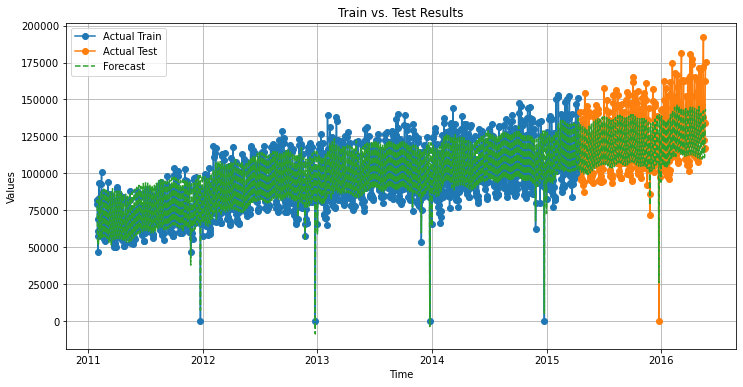

In [203]:
# Plot your train and test results
plt.figure(figsize=(12, 6))
plt.plot(data['ds'], data['y'], label='Actual Train', marker='o')
plt.plot(data_test['ds'], data_test['y'], label='Actual Test', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Total Revenue')
plt.title('Prophet Model')
plt.legend()
plt.grid(True)
plt.show()

In [204]:
import joblib

# Save the model to a file using joblib
joblib.dump(model, 'prophet_model.joblib')

['prophet_model.joblib']

In [211]:
# Input date in YYYY-MM-DD format
input_date = '2015-01-01'

# Convert the input date to a datetime object
start_date = pd.to_datetime(input_date)

# Calculate the end date by adding 6 days to the start date
end_date = start_date + pd.DateOffset(days=6)

# Generate a date range for the week
date_range = pd.date_range(start=start_date, end=end_date)

# Create a DataFrame with a 'ds' column
df = pd.DataFrame({'ds': date_range})


# Fit the model with your historical data (if available)
# model.fit(your_historical_data)

# Make predictions for the week
forecast = model.predict(df)

# Extract the 'ds' and 'yhat' columns for the week
result = forecast[['ds', 'yhat']]

result['ds'] = pd.to_datetime(result['ds']).dt.date.str

# Rename columns for output
result.columns = ['date', 'value']

# Output the result as a dictionary
result_dict = result.set_index('date').to_dict()['value']

# Print the result
print(result_dict)


{datetime.date(2015, 1, 1): 72824.5008296067, datetime.date(2015, 1, 2): 107123.54931032738, datetime.date(2015, 1, 3): 127025.67751535491, datetime.date(2015, 1, 4): 127813.97661515199, datetime.date(2015, 1, 5): 102218.88337200356, datetime.date(2015, 1, 6): 95797.99442306712, datetime.date(2015, 1, 7): 93962.7265274284}


<ipython-input-211-376f6481e7ff>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['ds'] = pd.to_datetime(result['ds']).dt.date


In [212]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/rush/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1541
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -16937.111
Date:                Thu, 05 Oct 2023   AIC                          33880.222
Time:                        08:26:08   BIC                          33896.241
Sample:                    01-29-2011   HQIC                         33886.182
                         - 04-18-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4940      0.025     20.080      0.000       0.446       0.542
ma.L1         -0.9836      0.007   -131.166      0.000      -0.998      -0.969
sigma2      2.597e+08   2.84e-12   9.13e+19      0.0

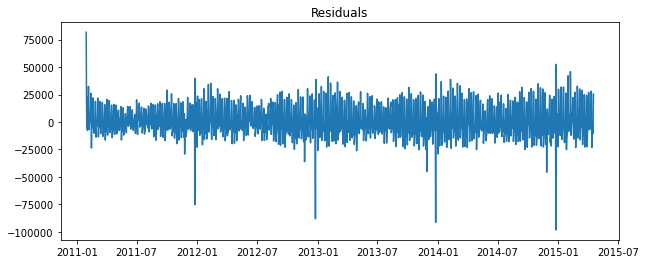

<ipython-input-15-e2c4296a19c9>:43: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, closed='right')


ValueError: x and y must have same first dimension, but have shapes (400,) and (401,)

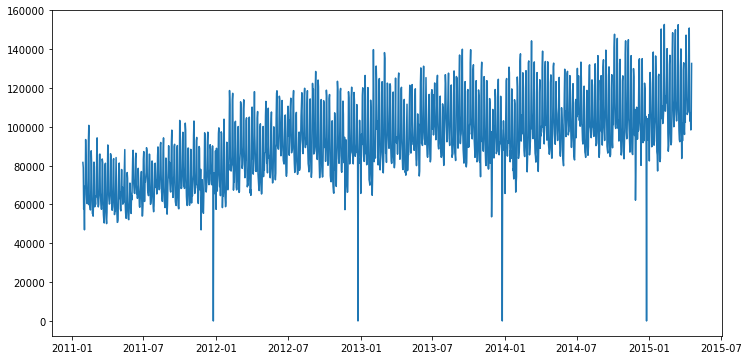

In [15]:


# Load your time series data into a pandas DataFrame
# Replace this with your own data loading code
# Example: df = pd.read_csv('your_data.csv')
# Ensure that you have a 'date' column and a 'value' column

# Assuming 'date' is your date column, set it as the index
def fitarima(df):
    #df['ds'] = pd.to_datetime(df['ds'])
    #df.set_index('ds', inplace=True)

    # Check for stationarity and apply differencing if needed
    # Use Augmented Dickey-Fuller test or other methods to check for stationarity
    # Example: df_diff = df.diff().dropna()

    # Define the ARIMA model parameters
    p = 1  # Order of the autoregressive (AR) component
    d = 1  # Order of differencing (usually 1 or 2)
    q = 1  # Order of the moving average (MA) component

    # Create and fit the ARIMA model
    model = sm.tsa.ARIMA(df, order=(p, d, q))
    results = model.fit()

    # Print a summary of the model
    print(results.summary())

    # Plot the residuals
    residuals = results.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.show()

    # Make forecasts
    forecast_steps = 400  # Number of time steps into the future to forecast
    forecast = results.forecast(steps=forecast_steps)

    # Create a new index for the forecasted values
    forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, closed='right')



    # Plot the original time series and the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df, label='Original Time Series')
    plt.plot(pd.date_range(start=df.index[-1], periods=forecast_steps+1, closed='right'), np.append(df.iloc[-1], forecast), label='Forecast', linestyle='--')
    plt.legend()
    plt.title('ARIMA Forecast')
    plt.show()

fitarima(train_df)
